In [38]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
import keras

In [2]:
def get_data_frame():
    current_folder = os.getcwd()
    file_path = os.path.join(current_folder,'..' ,'resource', 'RSMC_Best_Track_Data.csv')
    df = pd.read_csv(file_path)
    
    new_order = [
    'International number ID',
    'Name of the storm',
    'Time of analysis',
    'Grade',
    'Central pressure',
    'Maximum sustained wind speed',
    'Direction of the longest radius of 50kt winds or greater',
    'The longest radius of 50kt winds or greater',
    'The shortest radius of 50kt winds or greater',
    'Direction of the longest radius of 30kt winds or greater',
    'The longest radius of 30kt winds or greater',
    'The shortest radius of 30kt winds or greater',
    'Indicator of landfall or passage',
    'Latitude of the center',
    'Longitude of the center'
]

    df = df[new_order]
    
    # -------------------------
    df['Latitude of the center_next'] = float('nan')
    df['Longitude of the center_next'] = float('nan')

# 遍历每个国际编号（International number ID）
    for international_id in df['International number ID'].unique():
    # 获取该国际编号的所有行
        rows = df[df['International number ID'] == international_id]
    
    # 遍历每行，设置Latitude of the center_next 和 Longitude of the center_next
        for i in range(len(rows) - 1):
            df.at[rows.index[i], 'Latitude of the center_next'] = rows.at[rows.index[i + 1], 'Latitude of the center']
            df.at[rows.index[i], 'Longitude of the center_next'] = rows.at[rows.index[i + 1], 'Longitude of the center']

# 处理每组国际编号的最后一行
    for international_id in df['International number ID'].unique():
        rows = df[df['International number ID'] == international_id]
        last_index = rows.index[-1]
        df.drop(last_index, inplace=True)
    
    # 处理最后一行数据
    # df.at[last_index, 'Latitude of the center_next'] = df.at[last_index, 'Latitude of the center']
    # df.at[last_index, 'Longitude of the center_next'] = df.at[last_index, 'Longitude of the center']

    # ---------------------------

    direction_30_mapping = {'(symmetric circle)': 1, 'Northeast (NE)': 6, 'South (S)': 3,
                            'East (E)': 5, 'Southeast (SE)': 9, 'West (W)': 4, 'North (N)': 2,
                            'Northwest (NW)': 6, 'Southwest (SW)': 8}
    df['Direction of the longest radius of 30kt winds or greater'] = df[
        'Direction of the longest radius of 30kt winds or greater'].map(direction_30_mapping)

    direction_50_mapping = {'(symmetric circle)': 1, 'Northeast (NE)': 6, 'South (S)': 3,
                            'East (E)': 5, 'Southeast (SE)': 9, 'West (W)': 4, 'North (N)': 2,
                            'Northwest (NW)': 6, 'Southwest (SW)': 8,
                            'No direction (Longest radius of 50kt winds is 0)': 9}
    df['Direction of the longest radius of 50kt winds or greater'] = df[
        'Direction of the longest radius of 50kt winds or greater'].map(direction_50_mapping)

    indicator_mapping = {'#': 1, ' ': 0}
    df['Indicator of landfall or passage'] = df['Indicator of landfall or passage'].map(indicator_mapping)

    # ----------------------

    df = df.drop(['International number ID', 'Name of the storm', 'Grade'], axis=1)
    columns_to_check = [
        'Direction of the longest radius of 50kt winds or greater',
        'The longest radius of 50kt winds or greater',
        'The shortest radius of 50kt winds or greater',
        'Direction of the longest radius of 30kt winds or greater',
        'The longest radius of 30kt winds or greater',
        'The shortest radius of 30kt winds or greater'
    ]
    df = df.dropna(subset=columns_to_check)

    # -----------------------

    one_hot_encoded = pd.get_dummies(df['Direction of the longest radius of 50kt winds or greater'],
                                     prefix='Direction of the longest radius of 50kt winds or greater', dtype=int)
    df = pd.concat([df, one_hot_encoded], axis=1)

    one_hot_encoded2 = pd.get_dummies(df['Direction of the longest radius of 30kt winds or greater'],
                                      prefix='Direction of the longest radius of 30kt winds or greater', dtype=int)
    df = pd.concat([df, one_hot_encoded2], axis=1)
    df = df.drop(['Direction of the longest radius of 50kt winds or greater',
                  'Direction of the longest radius of 30kt winds or greater'], axis=1)

    # ----------------------

    df['Time of analysis'] = pd.to_datetime(df['Time of analysis'])
    df['Time of analysis'] = df['Time of analysis'].apply(lambda x: x.timestamp())

    # -----------------------
    return df

In [3]:
def min_max_scaler():
    
    df = get_data_frame()
    
    columns_to_normalize = df.columns[:]

    # 实例化 MinMaxScaler
    scaler = MinMaxScaler()

    # 对选择的列进行归一化
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    # 打印处理后的新 DataFrame 的信息
    df.tail()

    return df

In [4]:
def split_data():
    df = min_max_scaler()
    split_index = int(0.7 * len(df))

    # 分割DataFrame
    train_set = df.iloc[:split_index, :]
    test_set = df.iloc[split_index:, :]

    train_x = train_set.drop(["Latitude of the center_next", "Longitude of the center_next"], axis=1)
    train_y = train_set.loc[:, ["Latitude of the center_next", "Longitude of the center_next"]]
    test_x = test_set.drop(["Latitude of the center_next", "Longitude of the center_next"], axis=1)
    test_y = test_set.loc[:, ["Latitude of the center_next", "Longitude of the center_next"]]
    # 给训练集的标签打上时间序列
    first_column = train_x.iloc[:, 0]
    train_y.insert(0, 'Time of analysis', first_column)
    

    return train_x, train_y, test_x, test_y


In [5]:
df = min_max_scaler()
x_train, y_train, text_x, test_y = split_data()

In [19]:
df

,Time of analysis,Central pressure,Maximum sustained wind speed,The longest radius of 50kt winds or greater,The shortest radius of 50kt winds or greater,The longest radius of 30kt winds or greater,The shortest radius of 30kt winds or greater,Indicator of landfall or passage,Latitude of the center,Longitude of the center,...,Direction of the longest radius of 50kt winds or greater_8.0,Direction of the longest radius of 50kt winds or greater_9.0,Direction of the longest radius of 30kt winds or greater_1.0,Direction of the longest radius of 30kt winds or greater_2.0,Direction of the longest radius of 30kt winds or greater_3.0,Direction of the longest radius of 30kt winds or greater_4.0,Direction of the longest radius of 30kt winds or greater_5.0,Direction of the longest radius of 30kt winds or greater_6.0,Direction of the longest radius of 30kt winds or greater_8.0,Direction of the longest radius of 30kt winds or greater_9.0
25272,0.000000,0.857143,0.142857,0.000000,0.00,0.126506,0.208333,0.0,0.084536,0.717887,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25273,0.000015,0.900000,0.142857,0.000000,0.00,0.126506,0.208333,0.0,0.094845,0.710684,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25274,0.000030,0.928571,0.142857,0.000000,0.00,0.126506,0.208333,0.0,0.105155,0.702281,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25275,0.000044,0.942857,0.095238,0.000000,0.00,0.096386,0.166667,0.0,0.113402,0.693878,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25276,0.000059,0.942857,0.095238,0.000000,0.00,0.096386,0.166667,0.0,0.119588,0.684274,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68727,0.999941,0.750000,0.238095,0.246154,0.24,0.301205,0.250000,0.0,0.468041,0.403361,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
68728,0.999956,0.785714,0.190476,0.246154,0.24,0.337349,0.250000,0.0,0.496907,0.417767,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
68729,0.999970,0.785714,0.190476,0.215385,0.20,0.337349,0.250000,0.0,0.513402,0.435774,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
68730,0.999985,0.785714,0.190476,0.184615,0.16,0.337349,0.250000,0.0,0.544330,0.454982,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [34]:
verbose, epochs, batch_size = 1, 5, 16

# Assuming x_train and y_train have shapes: (samples, features) for both x_train and y_train
n_features_x, n_outputs_x = x_train.shape[1], y_train.shape[1]
n_features_y = y_train.shape[1]

# reshape output into [samples, features]
y_train_reshaped = y_train.values.reshape((y_train.shape[0], y_train.shape[1], 1))

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_features_x, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(n_outputs_x))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))  # Adjust the number of units to match the number of features in the output
model.compile(loss='mse', optimizer='adam')

# fit network
model.fit(x_train.values, y_train_reshaped, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/5
1194/1194 [==============================] - 9s 6ms/step - loss: 0.0046
Epoch 2/5
1194/1194 [==============================] - 7s 6ms/step - loss: 3.0095e-04
Epoch 3/5
1194/1194 [==============================] - 7s 6ms/step - loss: 2.1636e-04
Epoch 4/5
1194/1194 [==============================] - 7s 6ms/step - loss: 2.0241e-04
Epoch 5/5
1194/1194 [==============================] - 8s 6ms/step - loss: 1.7830e-04


In [44]:
test_head_y = test_y.loc[text_x.index[-20:-15]]

test_head_x = text_x.loc[text_x.index[-20:-15]]

test_tail_y = test_y.loc[text_x.index[-15:]]

test_tail_x = text_x.loc[text_x.index[-15:]]

In [39]:
model_pre = keras.models.load_model(r'C:\CODE\tropical_cyclone_prediction\model\CNN-LSTM-20-50.keras')

1/1 [==============================] - 0s 20ms/step


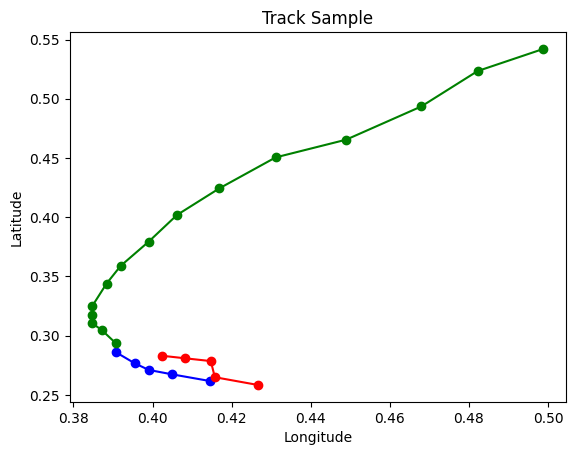

In [46]:

testPredict = model.predict(test_head_x)

#test_head
plt.plot(test_head_y['Longitude of the center_next'], test_head_y['Latitude of the center_next'], color='blue', marker='o')
#test_tail
plt.plot(test_tail_y['Longitude of the center_next'], test_tail_y['Latitude of the center_next'], color = 'green', marker='o')
#predict
plt.plot(testPredict[:, 2], testPredict[:, 1], label='numpy_array', color='red', marker='o')



# 设置图表标题和轴标签
plt.title('Track Sample')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 显示图表
plt.show()